### Library import

In [1]:
# basic library
import numpy as np
import pandas as pd

# models
from sklearn.tree import DecisionTreeClassifier

# custom modules
from utils import set_seed, get_clf_eval, make_submission, record_experimental_results
import preprocessing as pp

# preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

### Global Setting

In [2]:
hparams = {
    'seed': 33,
}

In [3]:
set_seed(hparams['seed'])

### 실험 01: Positive sample (`is_converted == True`) oversampling
- `Imbalanced-learn` 라이브러리를 활용하여, positive sample을 oversampling 후 학습
- 모델은 DecisionTree를 그대로 사용
- 모든 Feature를 사용

**Data preprocessing**

In [25]:
# data load & label encoding
tr_data, tt_data = pp.load_data()
x_tr, x_tt = pp.label_encoding(tr_data, tt_data)

In [8]:
# oversampling
ros = RandomOverSampler(random_state=hparams['seed'])
x_tr_res, y_tr_res = ros.fit_resample(x_tr.drop(['is_converted'], axis=1), x_tr['is_converted'])

In [10]:
print(f'[Before oversampling] size of training data : {len(x_tr)}')
print(f'[After oversampling] size of training data : {len(x_tr_res)}')

from collections import Counter

print(f'[After oversampling] distribution of training data : {Counter(y_tr_res)}')

[Before oversampling] size of training data : 59299
[After oversampling] size of training data : 108898
[After oversampling] distribution of training data : Counter({True: 54449, False: 54449})


In [12]:
# train / validation split
x_tr_res['is_converted'] = y_tr_res # concat
x_tr, y_tr, x_val, y_val = pp.split_train_and_validation(x_tr_res, seed=hparams['seed'])

**Select a model**
- `DecisionTreeClassifier()`

In [13]:
model = DecisionTreeClassifier()

**Training**

In [15]:
model.fit(x_tr.fillna(0), y_tr)

DecisionTreeClassifier()

**Check validation score**

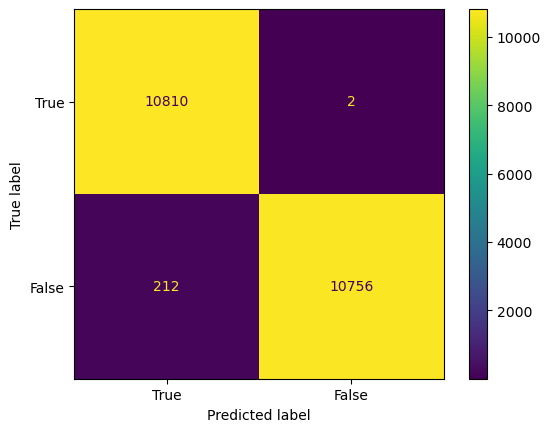


정확도: 0.9902
정밀도: 0.9808
재현율: 0.9998
F1: 0.9902


In [16]:
y_val_pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, y_val_pred)

**Make a submission file**

In [17]:
x_tt = x_tt.drop(['is_converted', 'id'], axis=1)

In [18]:
y_test_pred = model.predict(x_tt.fillna(0))
sum(y_test_pred)

599

In [19]:
make_submission(dir_name='02_use_sampler',
                f1_val=0.9902,
                y_pred=y_test_pred)

**Record**

In [20]:
record_experimental_results(model_name='decision_tree_w_oversampling',
                            test_f1_score='0.39189189189189194',
                            description='모든 feature 사용/전처리 X/RandomOverSampler 적용/결측치는 0으로 채움/Seed 33/training data size: 108898')

---

### 실험 02: Negative sample (`is_converted == False`) undersampling
- Negative sample : Positive sample = 54449 : 4850 으로 sample 수 차이가 너무 많이 나는 상황
- Positive sample에 대해, 증강 없이 oversampling 하는 경우 training data의 positive sample에 overfitting.
- 전체 data가 너무 줄어드는 것 같기는 하지만, `is_converted == False` 데이터를 undersampling 하여 성능을 측정해본다.

In [5]:
# data load & label encoding
tr_data, tt_data = pp.load_data()
x_tr, x_tt = pp.label_encoding(tr_data, tt_data)

In [6]:
# undersampling
rus = RandomUnderSampler(random_state=hparams['seed'])
x_tr_res, y_tr_res = rus.fit_resample(x_tr.drop(['is_converted'], axis=1), x_tr['is_converted'])

In [8]:
print(f'[Before undersampling] size of training data : {len(x_tr)}')
print(f'[After undersampling] size of training data : {len(x_tr_res)}')

from collections import Counter

print(f'[After undersampling] distribution of training data : {Counter(y_tr_res)}')

[Before undersampling] size of training data : 59299
[After undersampling] size of training data : 9700
[After undersampling] distribution of training data : Counter({False: 4850, True: 4850})


In [9]:
# train / validation split
x_tr_res['is_converted'] = y_tr_res # concat
x_tr, y_tr, x_val, y_val = pp.split_train_and_validation(x_tr_res, seed=hparams['seed'])

In [10]:
print(f'training data size : {len(x_tr)}, validation data size: {len(x_val)}')

training data size : 7760, validation data size: 1940


**Select a model**
- `DecisionTreeClassifier()`

In [11]:
model = DecisionTreeClassifier()

**Training**

In [12]:
model.fit(x_tr.fillna(0), y_tr)

DecisionTreeClassifier()

**Check validation score**

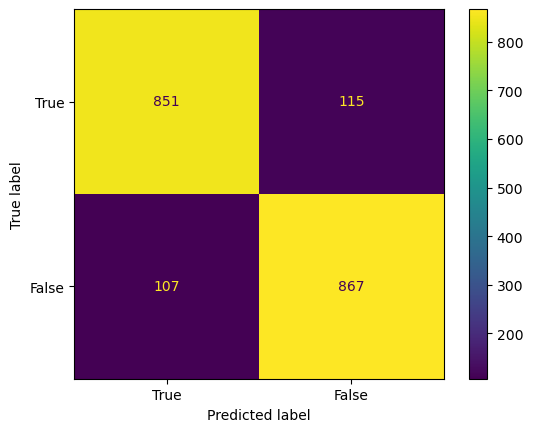


정확도: 0.8856
정밀도: 0.8883
재현율: 0.8810
F1: 0.8846


In [13]:
y_val_pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, y_val_pred)

**Make a submission file**

In [12]:
x_tt = x_tt.drop(['is_converted', 'id'], axis=1)

In [13]:
y_test_pred = model.predict(x_tt.fillna(0))
sum(y_test_pred)

2153

In [14]:
make_submission(dir_name='02_use_sampler',
                f1_val=0.8846,
                y_pred=y_test_pred)

**Record**

In [15]:
record_experimental_results(model_name='decision_tree_w_undersampling',
                            test_f1_score='0.5867215645908389',
                            description='모든 feature 사용/전처리 X/RandomUnderSampler 적용/결측치는 0으로 채움/Seed 33/training data size: 7760')

---

### 실험 03: Ensemble with undersampling
- 실험 02를 통해 undersampling 효과를 확인하였음.
- 실험 02에서 아쉬웠던 점은 sampling 하지 않은, 나머지 negative sample 들을 학습에 활용하지 못했다는 점.
- 서로 다른 seed를 사용하여 undersampling한 subset 들을 가지고, 각기 다른 decision tree model을 학습한 뒤, 이를 ensemble하여 결과를 만든다면 어떨까?
    - case1) test positive sample 입력 -> 모든 모델이 positive 라고 예측
    - case2) test negative sample 입력 -> 모델마다 학습한 negative sample이 다르기 때문에, 각기 다른 예측 -> voting을 통해 positive / negative 결정 -> FP 또는 FN 을 줄일 수 있을 것으로 예상

In [21]:
num_models = 20 # ensemble할 모델 개수
test_results = np.zeros((num_models, len(x_tt))) # 모델별 test 결과를 저장할 배열

In [ ]:
# ensemble loop
for i in range(num_models):
    # data load & label encoding
    x_tr, x_tt = pp.label_encoding(tr_data, tt_data)

    # 서로 다른 seed를 이용하여 undersampling 수행
    rus = RandomUnderSampler(random_state=hparams['seed'] + i)
    x_tr_res, y_tr_res = rus.fit_resample(x_tr.drop(['is_converted'], axis=1), x_tr['is_converted'])

    # train / validation split
    x_tr_res['is_converted'] = y_tr_res # concat
    x_tr, y_tr, x_val, y_val = pp.split_train_and_validation(x_tr_res, seed=hparams['seed'])

    # define a model
    model = DecisionTreeClassifier()

    # training
    model.fit(x_tr.fillna(0), y_tr)

    # test
    x_tt = x_tt.drop(['is_converted', 'id'], axis=1)
    y_test_pred = model.predict(x_tt.fillna(0))

    # 예측 결과를 array에 누적
    test_results[i, :] = y_test_pred
    

    ### print result of current model ###
    print('-' * 20)
    print(f'Model {i + 1} results')
    print('-' * 20)

    print(f'current seed: {hparams["seed"] + i}')

    # check validation score
    y_val_pred = model.predict(x_val.fillna(0))
    get_clf_eval(y_val, y_val_pred)

    # number of positive predictions
    print(sum(y_test_pred))
    print()

In [23]:
# hard voting -> 모델별 예측 결과 (1 또는 0) 를 모두 더한 뒤, 합이 5 이상이면 1 (positive), 5 미만이면 0 (negative) 로 예측
tmp = np.sum(test_results, axis=0, dtype=int)
final_test_pred = np.array([1 if x >= 5 else 0 for x in tmp])

In [24]:
sum(final_test_pred)

3185

In [25]:
make_submission(dir_name='02_use_sampler',
                f1_val=0.89215,
                y_pred=final_test_pred)

**Record**

In [26]:
record_experimental_results(model_name='ensemble_decisiontree_w_undersampling',
                            test_f1_score='0.6497337156902908',
                            description='20개 decision tree 사용/seed33~52/mean validation f1 score 0.89215/hard voting/결측치 0으로 처리')

---

### 실험 04: decision tree with undersampling + feature preprocessing
- Sampling을 하지 않고, feature preprocessing을 한 뒤 decision tree를 학습했을 때 성능이 저하되었음.
- Negative / Positive sample 의 비율이 망가진 상태에서, feature preprocessing으로 인해 학습할 수 있는 정보가 줄어들면서 overfitting 현상이 더욱 심해졌기 때문이라고 생각하였음.
- 그렇다면, negative / positive sample의 비율을 맞춰준 상태에서, feature preprocessing 후 모델을 학습시킨다면 overfitting 문제를 해결할 수도 있겠다고 생각하였음.
- 현재 구현한 feature preprocessing에 대해 ablation study를 수행
---
**Ablation**
1. `customer_country` 와 correlation이 높은 `customer_country.1` feature를 삭제했을 때, 실험 02와 성능 비교 -> Test f1 score 0.03 상승
1. 실험 04_01 에서 성능 향상이 있었으므로, 결측치 비율이 높은 features를 추가 삭제한 뒤 04_01과 성능 비교 -> 실험 02보다도 test f1 score 감소
1. 실험 04_01 setting에서 `customer_country` 의 feature를 normalization 했을 때, 실험 04_01과 성능 비교 -> 실험 02보다도 test f1 score 감소

**Preprocessing01: `customer_country.1` feature 삭제**

In [33]:
# data load & label encoding & feature delete
tr_data, tt_data = pp.load_data()
x_tr, x_tt = pp.label_encoding(tr_data, tt_data)
x_tr, x_tt = pp.delete_features(x_tr, x_tt, features=['customer_country.1'])

print(len(tr_data.columns), len(x_tr.columns))

29 28


**Preprocessing02: feature별 결측치 비율을 확인한 뒤, 비율이 높은 feature 삭제**

In [55]:
tr_data, tt_data = pp.load_data()
tmp = pd.DataFrame(tr_data.isna().sum() / len(tr_data), columns=['nan_ratio'])

In [54]:
# 결측치 비율이 80% 이상인 feature 확인
tmp[tmp['nan_ratio'] >= 0.8].index

Index(['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver',
       'product_subcategory', 'product_modelname', 'business_subarea'],
      dtype='object')

In [56]:
# 80% 이상이 결측치인 feature + `customer_country.1` feature 삭제
x_tr, x_tt = pp.label_encoding(tr_data, tt_data)
x_tr, x_tt = pp.delete_features(x_tr, x_tt, features=['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver',
       'product_subcategory', 'product_modelname', 'business_subarea','customer_country.1'])

**Preprocessing03: `customer_country` feature normalization**

In [78]:
tr_data, tt_data = pp.load_data()

# feature 정규화
tr_data_cp, tt_data_cp = tr_data.copy(), tt_data.copy()
tr_data_cp['customer_country'] = pp.normalize_country_name(tr_data['customer_country'])
tt_data_cp['customer_country'] = pp.normalize_country_name(tt_data['customer_country'])

# label encoding & customer_country.1 feature 삭제
x_tr, x_tt = pp.label_encoding(tr_data_cp, tt_data_cp)
x_tr, x_tt = pp.delete_features(x_tr, x_tt, features=['customer_country.1'])

In [79]:
print(len(tr_data['customer_country'].unique()))
print(len(x_tr['customer_country'].unique()))

15400
583


In [80]:
# undersampling
rus = RandomUnderSampler(random_state=hparams['seed'])
x_tr_res, y_tr_res = rus.fit_resample(x_tr.drop(['is_converted'], axis=1), x_tr['is_converted'])

In [81]:
print(f'[Before undersampling] size of training data : {len(x_tr)}')
print(f'[After undersampling] size of training data : {len(x_tr_res)}')

from collections import Counter

print(f'[After undersampling] distribution of training data : {Counter(y_tr_res)}')

[Before undersampling] size of training data : 59299
[After undersampling] size of training data : 9700
[After undersampling] distribution of training data : Counter({False: 4850, True: 4850})


In [82]:
# train / validation split
x_tr_res['is_converted'] = y_tr_res # concat
x_tr, y_tr, x_val, y_val = pp.split_train_and_validation(x_tr_res, seed=hparams['seed'])

In [83]:
print(f'training data size : {len(x_tr)}, validation data size: {len(x_val)}')

training data size : 7760, validation data size: 1940


**Select a model**
- `DecisionTreeClassifier()`

In [84]:
model = DecisionTreeClassifier()

**Training**

In [85]:
model.fit(x_tr.fillna(0), y_tr)

DecisionTreeClassifier()

**Check validation score**

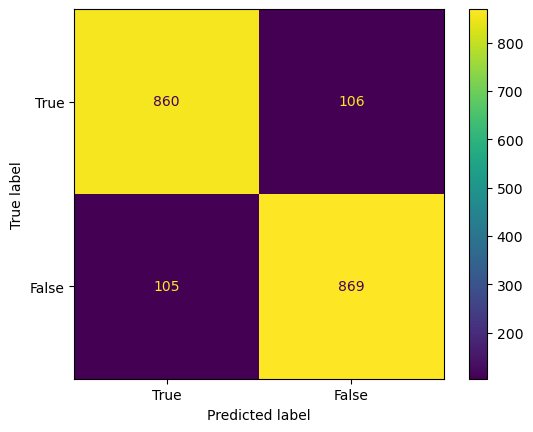


정확도: 0.8912
정밀도: 0.8912
재현율: 0.8903
F1: 0.8907


In [86]:
y_val_pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, y_val_pred)

**Make a submission file**

In [88]:
x_tt = x_tt.drop(['is_converted', 'id'], axis=1)

In [89]:
y_test_pred = model.predict(x_tt.fillna(0))
sum(y_test_pred)

2046

In [90]:
make_submission(dir_name='02_use_sampler',
                f1_val=0.8907,
                y_pred=y_test_pred)

**Record**

In [91]:
record_experimental_results(model_name='decision_tree_w_undersampling_feature_normalization',
                            test_f1_score='0.5541035023523261',
                            description='"customer_country" 정규화/"customer_country.1" feature 삭제/RandomUnderSampler 적용/결측치는 0으로 채움/Seed 33/training data size: 7760')

---

### 실험 05: Ensemble with undersampling + delete `customer_country.1`
- Test f1 score 향상이 있었던 실험 03과 04의 세팅을 합쳐 최종 실험
- 10개 decision tree ensemble / undersampling / delete `customer_country.1` feature

In [92]:
num_models = 10 # ensemble할 모델 개수
test_results = np.zeros((num_models, len(x_tt))) # 모델별 test 결과를 저장할 배열

In [ ]:
# ensemble loop
for i in range(num_models):
    # data load & label encoding & feature delete
    tr_data, tt_data = pp.load_data()
    x_tr, x_tt = pp.label_encoding(tr_data, tt_data)
    x_tr, x_tt = pp.delete_features(x_tr, x_tt, features=['customer_country.1'])
    

    # 서로 다른 seed를 이용하여 undersampling 수행
    rus = RandomUnderSampler(random_state=hparams['seed'] + i)
    x_tr_res, y_tr_res = rus.fit_resample(x_tr.drop(['is_converted'], axis=1), x_tr['is_converted'])

    # train / validation split
    x_tr_res['is_converted'] = y_tr_res # concat
    x_tr, y_tr, x_val, y_val = pp.split_train_and_validation(x_tr_res, seed=hparams['seed'])

    # define a model
    model = DecisionTreeClassifier()

    # training
    model.fit(x_tr.fillna(0), y_tr)

    # test
    x_tt = x_tt.drop(['is_converted', 'id'], axis=1)
    y_test_pred = model.predict(x_tt.fillna(0))

    # 예측 결과를 array에 누적
    test_results[i, :] = y_test_pred
    

    ### print result of current model ###
    print('-' * 20)
    print(f'Model {i + 1} results')
    print('-' * 20)

    print(f'current seed: {hparams["seed"] + i}')

    # check validation score
    y_val_pred = model.predict(x_val.fillna(0))
    get_clf_eval(y_val, y_val_pred)

    # number of positive predictions
    print(sum(y_test_pred))
    print()

In [94]:
# hard voting -> 모델별 예측 결과 (1 또는 0) 를 모두 더한 뒤, 합이 5 이상이면 1 (positive), 5 미만이면 0 (negative) 로 예측
tmp = np.sum(test_results, axis=0, dtype=int)
final_test_pred = np.array([1 if x >= 5 else 0 for x in tmp])

In [95]:
sum(final_test_pred)

2162

In [96]:
make_submission(dir_name='02_use_sampler',
                f1_val=0.89007,
                y_pred=final_test_pred)

**Record**

In [97]:
record_experimental_results(model_name='ensemble_decisiontree_w_undersampling_and_delete_feature',
                            test_f1_score='0.6381883685023161',
                            description='10개 decision tree 사용/"customer_country.1" feature 삭제/seed33~52/mean validation f1 score 0.89007/hard voting/결측치 0으로 처리')